In [336]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes

# Apply in 2D first

In [737]:
n_items = 16
dimensions = 2

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=10)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=11)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=12)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=13)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=14)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=15)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/voc

In [600]:
print("Fan1", np.linalg.norm(np.mean(fan1_pair_vecs, axis=0)))
print("Fan2", np.linalg.norm(np.mean(fan2_pair_vecs, axis=0)))
print("Both", np.linalg.norm(np.mean(fan2_pair_vecs+fan1_pair_vecs, axis=0)))

Fan1 0.1360229499619559
Fan2 0.3153942184304964
Both 0.10633993729801244


In [601]:
fan1_pairs = np.array(fan1_pair_vecs)
fan2_pairs = np.array(fan2_pair_vecs)

In [660]:
fan1_mean = np.mean(fan1_pair_vecs, axis=0)
fan2_mean = np.mean(fan2_pair_vecs, axis=0)

(-1.1, 1.1)

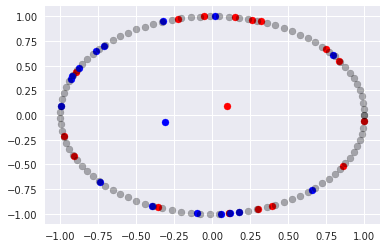

In [674]:
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

plt.scatter(fan1_pairs[:, 0], fan1_pairs[:, 1], label="cluster", color='r')
plt.scatter(fan1_mean[0], fan1_mean[1], color='r')
plt.scatter(fan2_pairs[:, 0], fan2_pairs[:, 1], label="spread", color='b')
plt.scatter(fan2_mean[0], fan2_mean[1], color='b')
plt.scatter(enc[:, 0], enc[:, 1], color='k', alpha=0.3)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

## Normal Voja Baseline

In [796]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [797]:
seed = 8

n_repeats = 5
t_pause = 0.4
t_present = 0.3
t_each = t_pause + t_present
n_neurons = 100

dt = 0.001

D = 2

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

intercepts = [0.7] * n_neurons

x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    conn_in = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(5e-4))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)

In [798]:
with nengo.Simulator(model) as sim:
    #sim.run(0.2)
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:19.                                                 


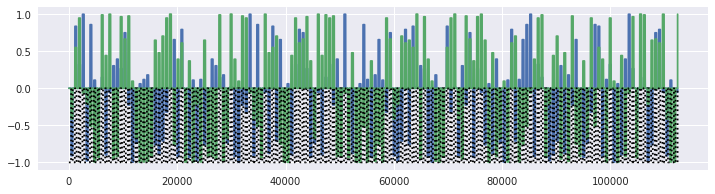

In [799]:
plt.figure(figsize=(12, 3))
plt.plot(sim.data[p_in])
plt.plot(sim.data[p_paused], color='k', linestyle=':')

(-1.1, 1.1)

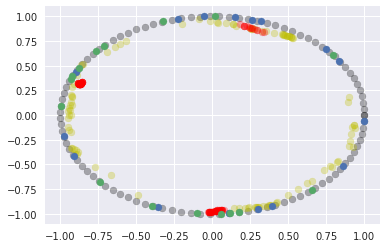

In [800]:
scale = (sim.data[ens].gain / ens.radius)[:, np.newaxis]
enc_hist = sim.data[p_enc]

init_enc = enc_hist[0].copy() / scale
mid_enc = enc_hist[len(enc_hist)//10].copy() / scale
fin_enc = enc_hist[-1].copy() / scale

plt.scatter(init_enc[:, 0], init_enc[:, 1], color='k', label="orig", alpha=0.3)
plt.scatter(mid_enc[:, 0], mid_enc[:, 1], color='y', label="mid", alpha=0.3)
plt.scatter(fin_enc[:, 0], fin_enc[:, 1], color='r', label="final", alpha=0.3)

plt.scatter(fan1_pairs[:, 0], fan1_pairs[:, 1], label="cluster")
plt.scatter(fan2_pairs[:, 0], fan2_pairs[:, 1], label="spread")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [801]:
len(enc_hist) // 10

112

In [802]:
with nengo.Network(seed=seed) as test_model:
    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[len(enc_hist)//10], intercepts=intercepts)
test_sim = nengo.Simulator(test_model)

Building finished in 0:00:01.                                                   


In [803]:
_, activity_clust = nengo.utils.ensemble.tuning_curves(ens, test_sim, inputs=fan1_pairs)
_, activity_sprd = nengo.utils.ensemble.tuning_curves(ens, test_sim, inputs=fan2_pairs)

In [804]:
columns = ("vec", "resp")

a1 = activity_clust.flatten()
l1 = ["fan1"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_sprd.flatten()
l2 = ["fan2"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

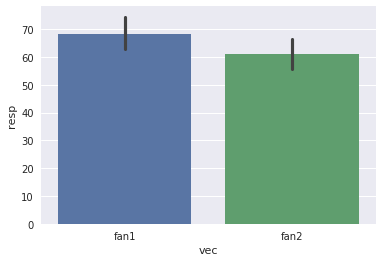

In [805]:
sns.barplot(x="vec", y="resp", data=acts)

## Add recurrent connections to see the effect

In [806]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[len(enc_hist)//10].copy(), intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:03.                                                 


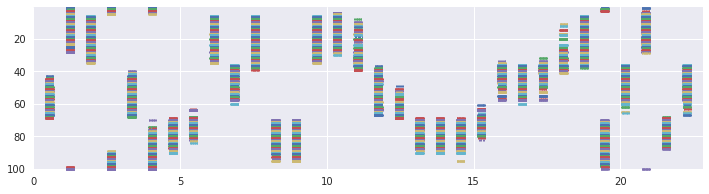

In [807]:
plt.figure(figsize=(12, 3))
no_inhib = sim.data[p_spikes].copy()
rasterplot(sim.trange(), sim.data[p_spikes])

In [823]:
mid_meg = sim.data[p_spikes].copy()

In [824]:
rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e3

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[len(enc_hist)//10].copy(), intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


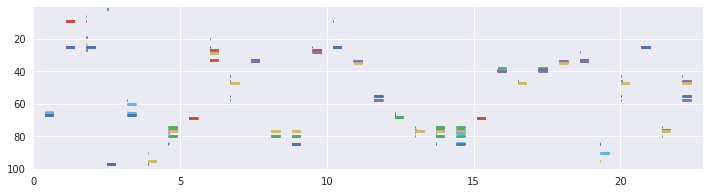

In [833]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [826]:
meg_sig = meg_from_spikes(sim.data[p_spikes])
mid_sig = meg_from_spikes(mid_meg)
alt_meg = meg_from_spikes(no_inhib)

In [827]:
clust_slc = slice(int(t_pause/dt), int(t_each/dt)*len(clust_vecs)+int(t_pause/dt))
sprd_slc = slice(clust_slc.stop, int(t_each/dt)*len(feed_vecs)+int(t_pause/dt))

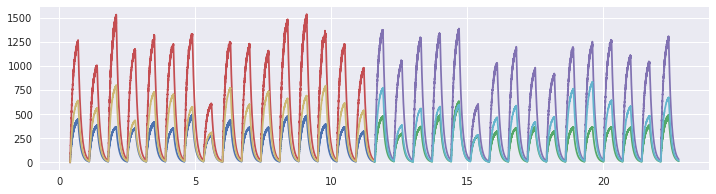

In [828]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[clust_slc], meg_sig[clust_slc])
plt.plot(sim.trange()[sprd_slc], meg_sig[sprd_slc])
plt.plot(sim.trange()[clust_slc], mid_sig[clust_slc])
plt.plot(sim.trange()[sprd_slc], mid_sig[sprd_slc])
plt.plot(sim.trange()[clust_slc], alt_meg[clust_slc]/10)
plt.plot(sim.trange()[sprd_slc], alt_meg[sprd_slc]/10)

In [813]:
print(np.mean(meg_sig[clust_slc]))
print(np.mean(meg_sig[sprd_slc]))
print(np.mean(alt_meg[clust_slc]))
print(np.mean(alt_meg[sprd_slc]))

537.4585943038894
499.5451052764165
2785.2877570728647
2489.5033554721736


In [814]:
print((np.mean(meg_sig[sprd_slc]) - np.mean(meg_sig[clust_slc])) / np.mean(meg_sig[sprd_slc]))
print((np.mean(alt_meg[sprd_slc]) - np.mean(alt_meg[clust_slc])) / np.mean(alt_meg[sprd_slc]))

-0.07589602745981064
-0.1188126141507413


In [831]:
columns = ("vec", "resp")

a1 = meg_sig[sprd_slc].flatten()
l1 = ["fan1"] * len(a1)
s1 = [True] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1), "inhib": s1})


a2 = meg_sig[clust_slc].flatten()
l2 = ["fan2"] * len(a2)
s2 = [True] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2), "inhib": s2})

a1 = alt_meg[sprd_slc].flatten()
l1 = ["fan1"] * len(a1)
s1 = [False] * len(a1)
p3 = pd.DataFrame({"vec": l1, "resp": list(a1), "inhib": s1})


a2 = alt_meg[clust_slc].flatten()
l2 = ["fan2"] * len(a2)
s2 = [False] * len(a2)
p4 = pd.DataFrame({"vec": l2, "resp": list(a2), "inhib": s2})

acts = pd.concat((p1, p2, p3, p4))

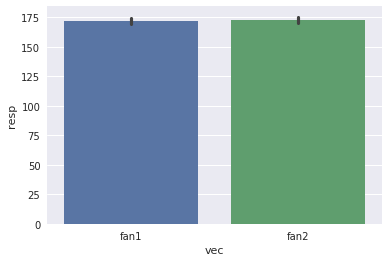

In [832]:
sns.barplot(x="vec", y="resp", data=acts[acts.inhib == True])

## Baseline recurrent connections

In [838]:
t_pause = 0.6
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e3

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


In [839]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

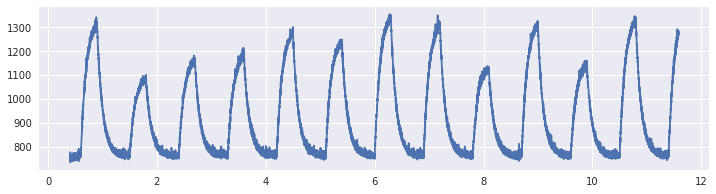

In [840]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[clust_slc], meg_sig[clust_slc])

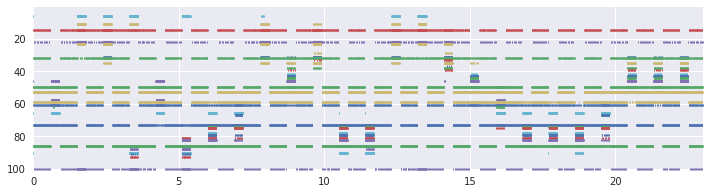

In [841]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [842]:
columns = ("vec", "resp")

a1 = meg_sig[sprd_slc].flatten()
l1 = ["fan1"] * len(a1)
s1 = [True] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1), "inhib": s1})


a2 = meg_sig[clust_slc].flatten()
l2 = ["fan2"] * len(a2)
s2 = [True] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2), "inhib": s2})

acts = pd.concat((p1, p2))

(800, 1000)

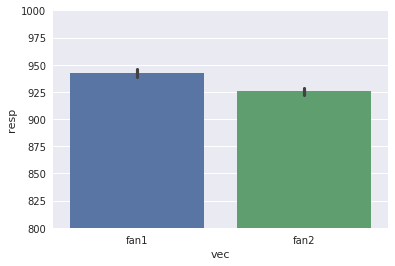

In [845]:
ax = sns.barplot(x="vec", y="resp", data=acts)
ax.set_ylim((800, 1000))

Still unclear if this is a sparse enough representation for learning and if this will also map foil pairs onto targets.

## Voja with recurrent inihibitory connections

In [741]:
seed = 8

n_repeats = 5
t_pause = 0.3
t_present = 0.3
t_each = t_pause + t_present
n_neurons = 100

D = 2

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

intercepts = [0.3] * n_neurons

rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e5

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)

    conn_in = nengo.Connection(in_nd, ens,learning_rule_type=nengo.Voja(5e-4))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)
    p_spikes = nengo.Probe(ens.neurons)

In [742]:
with nengo.Simulator(model) as sim:
    #sim.run(0.2)
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:07.                                                 


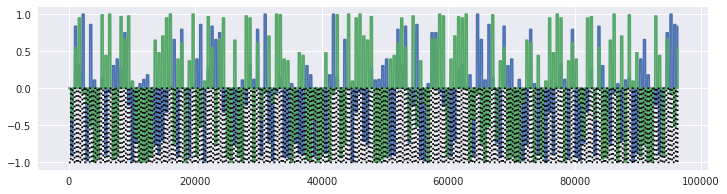

In [743]:
plt.figure(figsize=(12, 3))
plt.plot(sim.data[p_in])
plt.plot(sim.data[p_paused], color='k', linestyle=':')

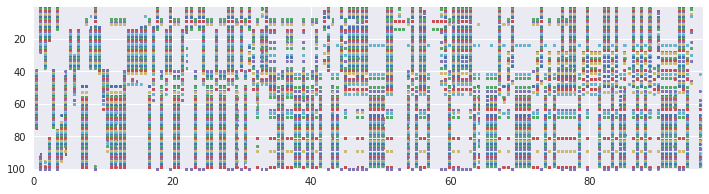

In [744]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

(-1.1, 1.1)

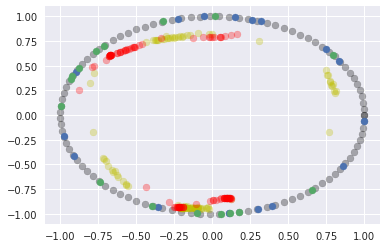

In [747]:
scale = (sim.data[ens].gain / ens.radius)[:, np.newaxis]
enc_hist = sim.data[p_enc]

init_enc = enc_hist[0].copy() / scale
mid_enc = enc_hist[len(enc_hist)//7].copy() / scale
fin_enc = enc_hist[-1].copy() / scale

plt.scatter(init_enc[:, 0], init_enc[:, 1], color='k', label="orig", alpha=0.3)
plt.scatter(mid_enc[:, 0], mid_enc[:, 1], color='y', label="mid", alpha=0.3)
plt.scatter(fin_enc[:, 0], fin_enc[:, 1], color='r', label="final", alpha=0.3)

plt.scatter(fan1_pairs[:, 0], fan1_pairs[:, 1], label="cluster")
plt.scatter(fan2_pairs[:, 0], fan2_pairs[:, 1], label="spread")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [653]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


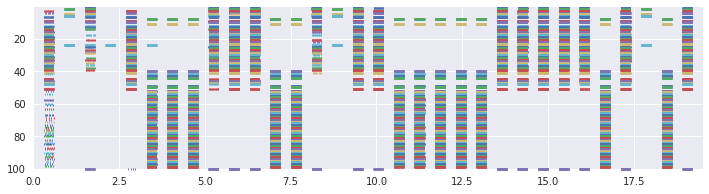

In [654]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [655]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [656]:
clust_slc = slice(int(t_pause/dt), int(t_each/dt)*len(clust_vecs)+int(t_pause/dt))
sprd_slc = slice(clust_slc.stop, int(t_each/dt)*len(feed_vecs)+int(t_pause/dt))

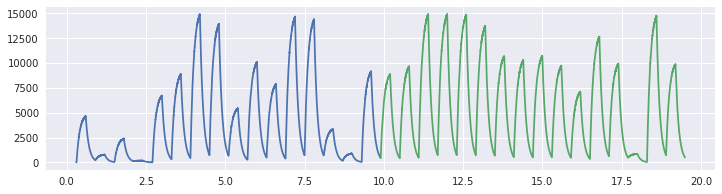

In [657]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[clust_slc], meg_sig[clust_slc])
plt.plot(sim.trange()[sprd_slc], meg_sig[sprd_slc])

## Negative Voja

In [ ]:
# make a model
# based off the reactions of the neurons, move the encoders towards the average of the last few activations

# Apply to full vocab

In [720]:
D = 32
n_neurons = 1000
seed = 8
n_items = 16

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, D, seed, norm=True)

In [721]:
print("Fan1", np.linalg.norm(np.mean(fan1_pair_vecs, axis=0)))
print("Fan2", np.linalg.norm(np.mean(fan2_pair_vecs, axis=0)))
print("Fan2", np.linalg.norm(np.mean(fan2_pair_vecs+fan1_pair_vecs, axis=0)))

Fan1 0.19959474872101687
Fan2 0.3340136847045675
Fan2 0.20512840215861833


In [722]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [723]:
seed = 8

n_repeats = 3
t_pause = 0.5
t_present = 0.3
t_each = t_pause + t_present

dt = 0.001

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)
intercepts = [0.3] * n_neurons

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts)

    conn_in = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(5e-4))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)

In [724]:
with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:03:05.                                                 


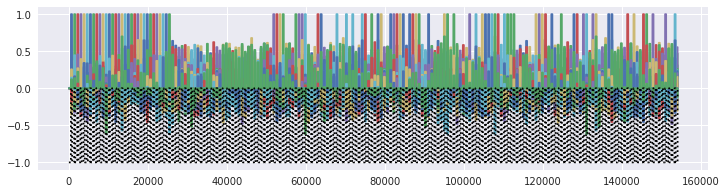

In [725]:
plt.figure(figsize=(12, 3))
plt.plot(spa.similarity(sim.data[p_in], fan1_pair_vecs+fan2_pair_vecs))
plt.plot(sim.data[p_paused], color='k', linestyle=':')

In [726]:
enc_hist = sim.data[p_enc]

with nengo.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [727]:
_, activity_fan1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_pair_vecs))
_, activity_fan2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_pair_vecs))

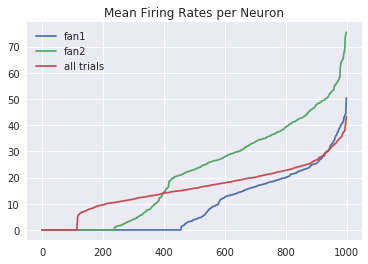

In [734]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(activity_fan1, axis=0)), label="fan1")
plt.plot(np.sort(np.mean(activity_fan2, axis=0)), label="fan2")
plt.plot(np.sort(np.mean(np.concatenate((activity_fan1, activity_fan2)), axis=0)), label="all trials")
plt.legend()

Number of neurons basically firing for both vectors
122


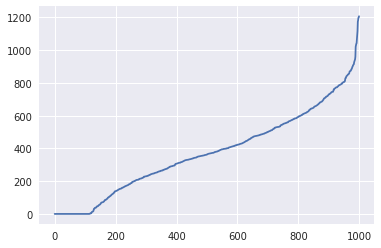

In [731]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(activity_fan1, axis=0) - np.sum(activity_fan2, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

In [733]:
print("Number of neurons basically not firing for either vector")
fire_diff = np.sort(np.abs(np.sum(activity_fan1, axis=0) + np.sum(activity_fan2, axis=0)))
len(fire_diff[fire_diff < 10])

Number of neurons basically not firing for either vector


115

In [728]:
columns = ("vec", "resp")

a1 = activity_fan1.flatten()
l1 = ["fan1"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_fan2.flatten()
l2 = ["fan2"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

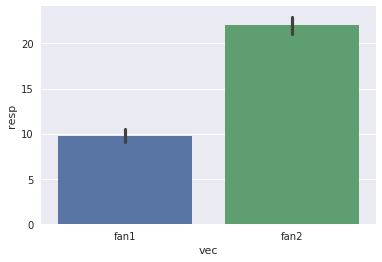

In [729]:
sns.barplot(x="vec", y="resp", data=acts)

## Add recurrent connections to see the effect

In [441]:
rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 2.5e4

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:15.                                                 


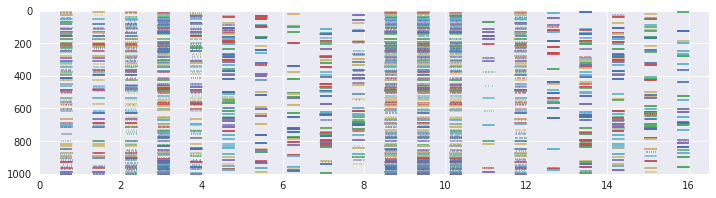

In [442]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [443]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [444]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs)+int(t_pause/dt))

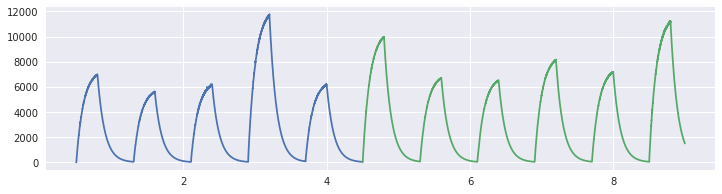

In [445]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_sig[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_sig[fan2_slc])

## Voja with recurrent inihibitory connections

In [537]:
seed = 8

n_repeats = 3
t_pause = 0.5
t_present = 0.3
t_each = t_pause + t_present
n_neurons = 100

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

intercepts = [0.3] * n_neurons

rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e5

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)

    conn_in = nengo.Connection(in_nd, ens,learning_rule_type=nengo.Voja(5e-2))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)
    p_spikes = nengo.Probe(ens.neurons)

In [538]:
with nengo.Simulator(model) as sim:
    #sim.run(0.2)
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:31.                                                 


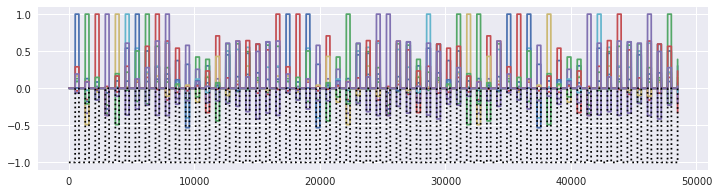

In [540]:
plt.figure(figsize=(12, 3))
plt.plot(spa.similarity(sim.data[p_in], fan1_pair_vecs+fan2_pair_vecs))
plt.plot(sim.data[p_paused], color='k', linestyle=':')

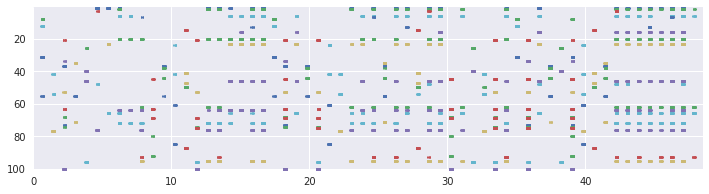

In [541]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [543]:
enc_hist = sim.data[p_enc].copy()
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


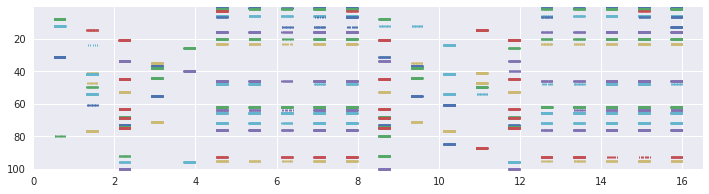

In [544]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [545]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [547]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs)+int(t_pause/dt))

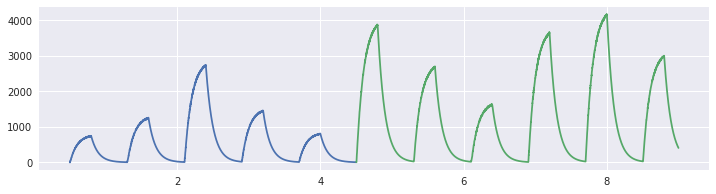

In [548]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_sig[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_sig[fan2_slc])